In [1]:
import pandas as pd
import numpy as np
%config IPCompleter.greedy=True
import findspark
findspark.init()

import time
import socket
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, lower, split, explode
import matplotlib.pyplot as plt
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
import socket

In [3]:
spark = SparkSession.builder \
        .appName("RecommendationSystem") \
        .master("local[*]") \
        .config("spark.executor.memory", "24g") \
        .config("spark.driver.memory", "24g") \
        .config("spark.executor.heartbeatInterval", "60s") \
        .config("spark.network.timeout", "2500s") \
        .config("spark.sql.shuffle.partitions", "200") \
        .config("spark.default.parallelism", "200") \
        .config("spark.executor.cores", "4") \
        .config("spark.driver.maxResultSize", "0") \
        .config("spark.memory.fraction", "0.6") \
        .config("spark.memory.storageFraction", "0.3") \
        .config("spark.executor.extraJavaOptions", "-Xss32M") \
        .config("spark.driver.extraJavaOptions", "-Xss32M") \
        .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC -XX:InitiatingHeapOccupancyPercent=35") \
        .config("spark.driver.extraJavaOptions", "-XX:+UseG1GC -XX:InitiatingHeapOccupancyPercent=35") \
        .getOrCreate()

In [4]:
spark.sparkContext.setCheckpointDir("/tmp_spark/checkpoints")

In [7]:
movies_df = spark.read.csv("movies.csv", header=True, inferSchema=True)
ratings_df = spark.read.csv("ratings.csv", header=True, inferSchema=True)

In [8]:
movies_df.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [9]:
ratings_df.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      1|   4.0|1225734739|
|     1|    110|   4.0|1225865086|
|     1|    158|   4.0|1225733503|
|     1|    260|   4.5|1225735204|
|     1|    356|   5.0|1225735119|
|     1|    381|   3.5|1225734105|
|     1|    596|   4.0|1225733524|
|     1|   1036|   5.0|1225735626|
|     1|   1049|   3.0|1225734079|
|     1|   1066|   4.0|1225736961|
|     1|   1196|   3.5|1225735441|
|     1|   1200|   3.5|1225735861|
|     1|   1210|   4.5|1225735210|
|     1|   1214|   4.0|1225736426|
|     1|   1291|   5.0|1225734809|
|     1|   1293|   2.0|1225733842|
|     1|   1376|   3.0|1225733539|
|     1|   1396|   3.0|1225733534|
|     1|   1537|   4.0|1225736687|
|     1|   1909|   3.0|1225733717|
+------+-------+------+----------+
only showing top 20 rows



In [10]:
ratings_df=ratings_df.drop("timestamp")

In [11]:
joined_df = movies_df.join(ratings_df, on="movieId", how="inner")

In [12]:
joined_df.show()

+-------+--------------------+--------------------+------+------+
|movieId|               title|              genres|userId|rating|
+-------+--------------------+--------------------+------+------+
|      1|    Toy Story (1995)|Adventure|Animati...|     1|   4.0|
|    110|   Braveheart (1995)|    Action|Drama|War|     1|   4.0|
|    158|       Casper (1995)|  Adventure|Children|     1|   4.0|
|    260|Star Wars: Episod...|Action|Adventure|...|     1|   4.5|
|    356| Forrest Gump (1994)|Comedy|Drama|Roma...|     1|   5.0|
|    381|When a Man Loves ...|       Drama|Romance|     1|   3.5|
|    596|    Pinocchio (1940)|Animation|Childre...|     1|   4.0|
|   1036|     Die Hard (1988)|Action|Crime|Thri...|     1|   5.0|
|   1049|Ghost and the Dar...|    Action|Adventure|     1|   3.0|
|   1066|Shall We Dance (1...|Comedy|Musical|Ro...|     1|   4.0|
|   1196|Star Wars: Episod...|Action|Adventure|...|     1|   3.5|
|   1200|       Aliens (1986)|Action|Adventure|...|     1|   3.5|
|   1210|S

In [13]:
joined_df.count()

33832162

In [14]:
from pyspark.sql.functions import col, sum

null_counts = joined_df.select(
    [(sum(col(c).isNull().cast("int")).alias(c)) for c in joined_df.columns]
)

null_counts.show()

+-------+-----+------+------+------+
|movieId|title|genres|userId|rating|
+-------+-----+------+------+------+
|      0|    0|     0|     0|     0|
+-------+-----+------+------+------+



In [15]:
train, test = joined_df.randomSplit([0.7, 0.3], seed=5065)
train.repartition(200)

DataFrame[movieId: int, title: string, genres: string, userId: int, rating: double]

In [14]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

ranks = [10, 50, 200]
iterations = [10, 50, 200]
lambdas = [0.01, 0.1]


results = []

# ALS modeli ve değerlendirme
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Model eğitimi ve değerlendirme
for rank in ranks:
    for iteration in iterations:
        for lambda_ in lambdas:
            als = ALS(
                maxIter=iteration,
                regParam=lambda_,
                rank=rank,
                userCol="userId",
                itemCol="movieId",
                ratingCol="rating",
                coldStartStrategy="drop",
                seed = 5065,
                checkpointInterval=5
            )
            try:
                # Modeli eğit
                model = als.fit(train)
                
                # Tahminler yap
                predictions = model.transform(test)
                
                # RMSE hesapla
                rmse = evaluator.evaluate(predictions)
                results.append((rank, iteration, lambda_, rmse))
                print(f"Rank: {rank}, Iteration: {iteration}, Lambda: {lambda_}, RMSE: {rmse}")
            except Exception as e:
                print(f"Rank: {rank}, Iteration: {iteration}, Lambda: {lambda_} -- Hata: {str(e)}")

Rank: 10, Iteration: 10, Lambda: 0.01, RMSE: 0.8279040274462465
Rank: 10, Iteration: 10, Lambda: 0.1, RMSE: 0.805986458208407
Rank: 10, Iteration: 50, Lambda: 0.01, RMSE: 0.8252724492110715
Rank: 10, Iteration: 50, Lambda: 0.1, RMSE: 0.8071773128891697
Rank: 10, Iteration: 200, Lambda: 0.01, RMSE: 0.8240729135220092
Rank: 10, Iteration: 200, Lambda: 0.1, RMSE: 0.8071971133190237
Rank: 50, Iteration: 10, Lambda: 0.01, RMSE: 0.8757648521699644
Rank: 50, Iteration: 10, Lambda: 0.1, RMSE: 0.809834909645543
Rank: 50, Iteration: 50, Lambda: 0.01, RMSE: 0.857887966676011
Rank: 50, Iteration: 50, Lambda: 0.1, RMSE: 0.8022554538595522
Rank: 50, Iteration: 200, Lambda: 0.01, RMSE: 0.8477344866087905
Rank: 50, Iteration: 200, Lambda: 0.1, RMSE: 0.8021963843650127
Rank: 200, Iteration: 10, Lambda: 0.01, RMSE: 0.8880645729789544
Rank: 200, Iteration: 10, Lambda: 0.1, RMSE: 0.8125542139041991
Rank: 200, Iteration: 50, Lambda: 0.01, RMSE: 0.8703335730858957
Rank: 200, Iteration: 50, Lambda: 0.1, RMSE

In [97]:
best_params = min(results, key=lambda x: x[3])  
best_rank, best_iteration, best_lambda, best_rmse = best_params

print("Best Model:")
print(f"Rank: {best_rank}, Iteration: {best_iteration}, Lambda: {best_lambda}, RMSE: {best_rmse}")


Best Model:
Rank: 50, Iteration: 200, Lambda: 0.1, RMSE: 0.8021963843650127


In [47]:
best_als = ALS(
    maxIter=best_iteration,
    regParam=best_lambda,
    rank=best_rank,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",
    seed=5065  ,
    checkpointInterval=5
)
# En iyi modeli yeniden eğit
best_model = best_als.fit(train)

# Tahminler yap
best_predictions = best_model.transform(test)

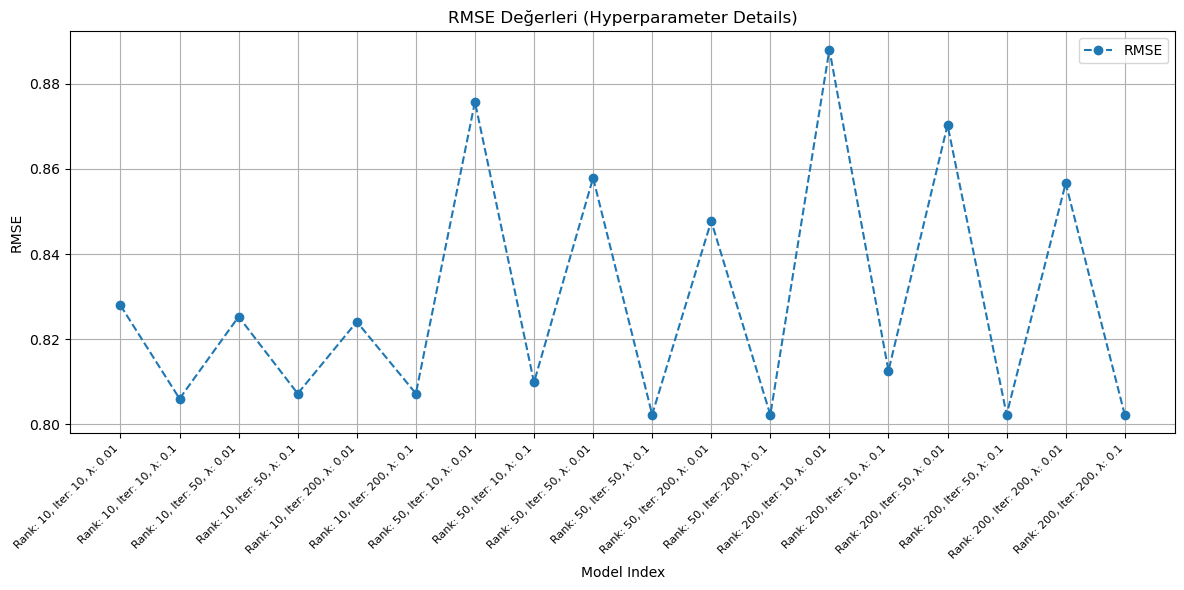

In [67]:
rmse_values = [row[3] for row in results]
labels = [f"Rank: {row[0]}, Iter: {row[1]}, λ: {row[2]}" for row in results]

plt.figure(figsize=(12, 6))
plt.plot(rmse_values, marker="o", linestyle="--", label="RMSE")
plt.title("RMSE Değerleri (Hyperparameter Details)")
plt.xlabel("Model Index")
plt.ylabel("RMSE")

plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha="right", fontsize=8)

plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()


In [51]:
best_predictions.show()

+-------+--------------------+------+------+------+----------+
|movieId|               title|genres|userId|rating|prediction|
+-------+--------------------+------+------+------+----------+
|    148|Awfully Big Adven...| Drama| 27466|   3.0| 2.6772532|
|    148|Awfully Big Adven...| Drama|311285|   3.0| 2.3209183|
|    148|Awfully Big Adven...| Drama| 79332|   4.0|  2.859521|
|    148|Awfully Big Adven...| Drama|  7169|   3.0| 2.8888812|
|    148|Awfully Big Adven...| Drama|157853|   1.0| 2.8207805|
|    148|Awfully Big Adven...| Drama|321974|   4.0| 3.2721207|
|    148|Awfully Big Adven...| Drama|177567|   5.0|  3.265095|
|    148|Awfully Big Adven...| Drama|313605|   3.0|   2.98452|
|    148|Awfully Big Adven...| Drama| 25022|   3.0| 2.8868332|
|    148|Awfully Big Adven...| Drama|170545|   1.0| 1.2486125|
|    148|Awfully Big Adven...| Drama| 47641|   3.0| 2.7623043|
|    148|Awfully Big Adven...| Drama|165757|   3.0| 2.6724765|
|    148|Awfully Big Adven...| Drama|179037|   2.0|   2

In [53]:
comparison_df = best_predictions.alias("pred") \
    .join(test.alias("test"), on=["userId", "movieId"], how="inner") \
    .select(
        col("test.rating").alias("actual_rating"),
        col("pred.prediction")
    )

print("Prediction vs Actual:")
comparison_df.show()

Prediction vs Actual:
+-------------+----------+
|actual_rating|prediction|
+-------------+----------+
|          4.5|   3.58103|
|          4.0|  3.649792|
|          3.5| 2.9693193|
|          3.5| 3.4384181|
|          2.0|  2.513557|
|          3.5|  3.407849|
|          4.0| 3.9124355|
|          4.5|  1.704893|
|          4.5|  3.651733|
|          4.0| 2.4694958|
|          5.0| 4.5014052|
|          4.5|  4.218081|
|          4.0|  4.158053|
|          2.5| 2.4628909|
|          4.0| 2.7151856|
|          5.0| 4.4796386|
|          4.5|  4.356238|
|          3.5| 3.3424137|
|          1.0| 2.4169042|
|          1.0| 2.1330757|
+-------------+----------+
only showing top 20 rows



In [54]:
user_factors = best_model.userFactors
item_factors = best_model.itemFactors

In [57]:
from pyspark.sql.functions import col, sum as spark_sum, udf

user_total_ratings = ratings_df.groupBy("userId").agg(
    sum("rating").alias("total_rating")
)

print("User Total Ratings:")
user_total_ratings.show()

User Total Ratings:
+------+------------+
|userId|total_rating|
+------+------------+
|   148|      1124.0|
|   463|       444.5|
|   471|        79.5|
|   496|       181.0|
|   833|       270.0|
|  1088|      1452.0|
|  1238|       145.0|
|  1342|       928.0|
|  1580|        19.0|
|  1591|        10.0|
|  1645|       806.0|
|  1829|        94.0|
|   243|        19.0|
|   392|      1554.0|
|   540|        66.0|
|   623|        66.5|
|   737|       739.0|
|   858|        12.0|
|   897|      7594.5|
|  1025|       114.0|
+------+------------+
only showing top 20 rows



In [58]:
from pyspark.sql.functions import col, lit, sqrt
from pyspark.ml.linalg import Vectors
import numpy as np
from functools import reduce


product_id = 22  #Any movieId you want
product_vector = item_factors.filter(col("id") == product_id).select("features").collect()[0][0]
product_vector = Vectors.dense(product_vector)


product_magnitude = np.linalg.norm(product_vector)


dot_product_expr = reduce(
    lambda acc, i: acc + (col("features")[i] * lit(product_vector[i])),
    range(len(product_vector)),
    lit(0)
)

user_magnitude_expr = sqrt(
    reduce(
        lambda acc, i: acc + (col("features")[i] ** 2),
        range(len(product_vector)),
        lit(0)
    )
)

user_factors = user_factors.withColumn("dot_product", dot_product_expr)
user_factors = user_factors.withColumn("user_magnitude", user_magnitude_expr)
user_factors = user_factors.withColumn(
    "cosine_similarity",
    col("dot_product") / (col("user_magnitude") * lit(product_magnitude))
)

top_users = (
    user_factors.orderBy(col("cosine_similarity").desc())
    .limit(10)
    .select("id")
)
product_title = joined_df.filter(col("movieId") == product_id).select("title").collect()[0][0]

top_users_with_title = top_users.withColumn("title", lit(product_title))

print(f"Determining the top 10 users most likely to enjoy {product_title}:")
top_users_with_title.show()


Determining the top 10 users most likely to enjoy Copycat (1995):
+------+--------------+
|    id|         title|
+------+--------------+
|244360|Copycat (1995)|
|135594|Copycat (1995)|
|223485|Copycat (1995)|
|258455|Copycat (1995)|
|225757|Copycat (1995)|
|190080|Copycat (1995)|
|247119|Copycat (1995)|
|283828|Copycat (1995)|
|226535|Copycat (1995)|
|208269|Copycat (1995)|
+------+--------------+



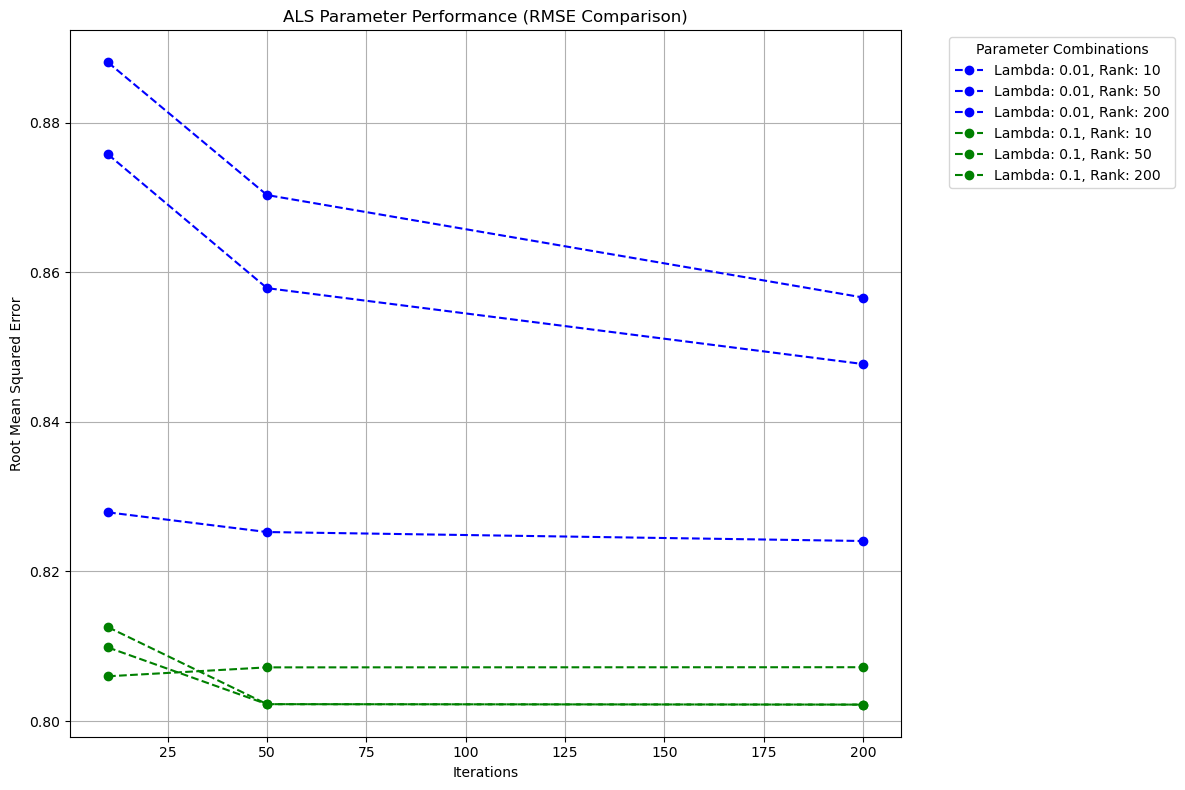

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results, columns=["Rank", "Iteration", "Lambda", "RMSE"])

plt.figure(figsize=(12, 8))


unique_lambdas = results_df["Lambda"].unique()
colors = ['b', 'g', 'r'] 

for lambda_, color in zip(unique_lambdas, colors):
    lambda_group = results_df[results_df["Lambda"] == lambda_]
    for rank in lambda_group['Rank'].unique():
        subset = lambda_group[lambda_group['Rank'] == rank]
        plt.plot(
            subset['Iteration'],
            subset['RMSE'],
            label=f"Lambda: {lambda_}, Rank: {rank}",
            marker='o',
            linestyle='--',
            color=color
        )

plt.title("ALS Parameter Performance (RMSE Comparison)")
plt.xlabel("Iterations")
plt.ylabel("Root Mean Squared Error")
plt.legend(title="Parameter Combinations", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.show()
